In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import gsw
from scipy.interpolate import interp1d
import xarray as xr
from datetime import datetime
from scipy.stats.distributions import chi2
from scipy import signal
from scipy.signal import fftconvolve as sci_fftconvolve
from scipy.signal import windows as windows
from scipy.optimize import curve_fit

In [2]:
transects = ['T12','T34','T56','T78']
WP_lat = [32.766478, 34.166816, 33.673312, 33.254831, 33.868988, 33.060534, 32.686389, 34.248285]
WP_lon = [-122.051875, -123.021175, -123.471025, -121.598714, -121.689333, -123.368057, -122.781231, -122.279467]
center = (33.466647, -122.536525)

# Reads in necessary files

In [3]:
df = pd.read_csv('../SR2006.uctd.data.csv')
tsg = pd.read_csv('../tsg.csv')
prof_uctd = xr.open_dataset('../prof_uctd.nc')
profs = xr.open_dataset("../prof_uctd_fft.nc")

# Get time columns in np datetim64 format
for column in tsg.columns:
    if 'time' in column:
        tsg[column] = tsg[column].astype(np.datetime64)
        
for column in df.columns:
    if 'time' in column:
        df[column] = df[column].astype(np.datetime64)

C:\Users\Ryan Eusebi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Masks bad uctd data
Mostly masking where probe 311 went bad for the salinity data
Some temperature data got masked too where some casts were very far separated from each other
The variable 'temp_const' has identical masking as sal_good, if you wanted to use temperature data over the identical regions we have available in the sal_good variable (which is the salinity variable with bad data masked)

In [4]:
prof_uctd['sal_good'] = prof_uctd.sal.where(~((prof_uctd.cast_time>np.datetime64('2020-08-13T02:50'))&(prof_uctd.probe==311)), other=np.nan)
prof_uctd['conductivity_good'] = prof_uctd.conductivity.where(~((prof_uctd.cast_time>np.datetime64('2020-08-13T02:50'))&(prof_uctd.probe==311)), other=np.nan)
prof_uctd['temp_good'] = prof_uctd.temp.where(~((prof_uctd.transect=='T12')&(prof_uctd.p==2)&(prof_uctd.dist_from_WP<10)), other=np.nan)

for var in ['sal','conductivity','temp']:
    prof_uctd[f'{var}_good'] = prof_uctd[f'{var}_good'].where(~((prof_uctd.transect=='T78')&(prof_uctd.p==3)&(prof_uctd.cast<3)), other=np.nan)

    
# now let's do the same thing, but apply all maskings to all variables evenly, so we can isolate the effects
# of sparse data on some variables' spectra

prof_uctd[f'temp_const'] = prof_uctd['temp'].where(~((prof_uctd.cast_time>np.datetime64('2020-08-13T02:50'))&(prof_uctd.probe==311)), other=np.nan)
prof_uctd[f'temp_const'] = prof_uctd['temp_const'].where(~((prof_uctd.transect=='T78')&(prof_uctd.p==3)&(prof_uctd.cast<3)), other=np.nan)  

# Get TSG or uctd profile in xarray form for given transect, pass, and pressure
prof_for_fft is for uctd
tsg_prof_for_fft is for tsg
These functions are used to get the profiles for fft (fast fourier transform)

If a pressure level is not specified for the uctd function, it just returns all pressure levels

the interp_res and boxcar functions are used as follows:
the raw data is interpolated to interp_res[0] interpolation, averaged using boxcar averaging with a window size of "boxcar" datapoints, and then is interpolated to a final resolution of interp_res[1]

If block=True, then the initial interpolation is achieved by averaging values using block averaging in windows of size "block" meters (instead of interpolating first and then rolling averaging)


Returns the xarray variables sal_good, density_good, pot_density_good, temp_good, and temp_const

In [5]:
pressure_coords = np.arange(1, 251, 1)

def prof_for_fft(transect, p, pressure=None, interp_res=[1,2], boxcar=3):
    dist_coords = np.arange(0.5, 180, interp_res[0])
    prof = prof_uctd.sel(transect=transect, p=p)
    prof = prof.sel(cast=slice(None, prof.num_casts.item()-1))
    prof = prof.assign_coords(cast=prof.dist_from_WP.values).rename({'cast':'dist'})
    prof = prof.interp(dist=dist_coords, kwargs={"bounds_error":"False"})

    for var in ['temp', 'sal', 'conductivity']:
        prof[f'{var}_good'] = prof[f'{var}_good'].interpolate_na(dim='dist', max_gap=5)
        prof[f'{var}_good'] = prof[f'{var}_good'].rolling(dist=boxcar).mean(center=True, min_periods=1)
        
    prof[f'temp_const'] = prof[f'temp_const'].interpolate_na(dim='dist', max_gap=5)
    prof[f'temp_const'] = prof[f'temp_const'].rolling(dist=boxcar).mean(center=True, min_periods=1)
        
    # Decimate back up to lower resolution 
    dist_coords = np.arange(0.5, 180, interp_res[1])
    prof = prof.interp(dist=dist_coords, kwargs={"bounds_error":"False"})
    prof['density_good'] = gsw.rho_t_exact(prof.sal_good, prof.temp_good, prof.pressure)
    prof['pot_density_good'] = gsw.pot_rho_t_exact(prof.sal_good, prof.temp_good, prof.pressure, 0)
        
    if pressure is not None:
        prof = prof.interp(pressure=pressure)
    return prof

def tsg_prof_for_fft(transect, p, interp_res = [2,4], boxcar=1, hanning=False, block=False): 
    a = tsg[(tsg.transect==transect)&(tsg.transect_pass==p)].sort_values('dist_from_WP')
    
    if block:
        tsg_dist_coords = np.arange(interp_res[1]/2, 180000, interp_res[1]) / 1000 # convert back to km
        prof = xr.Dataset(coords=dict(dist=(['dist'], tsg_dist_coords)))
        for var in ['temp', 'sal', 'conductivity']:
            prof[f'{var}_good'] = block_avg(a[var], a.dist_from_WP, tsg_dist_coords, interp_res[1]/1000, fac=0.5)
        
    else:
        prof = xr.Dataset(data_vars=dict(sal_good=(['dist'], a.sal), temp_good=(['dist'], a.temp),
                                    conductivity_good=(['dist'], a.conductivity)),
                      coords=dict(dist=(['dist'], a.dist_from_WP.values)))
        tsg_dist_coords = np.arange(interp_res[0]/2, 180000, interp_res[0]) / 1000 # convert back to km
        prof = prof.interp(dist=tsg_dist_coords, kwargs={"bounds_error":"False"})
        if hanning:
            prof = prof.rolling(dist=boxcar).construct(window_dim='window')
            for var in ['temp', 'sal', 'conductivity']:
                prof[f'{var}_good'] = (prof[f'{var}_good']*np.hanning(boxcar)/np.hanning(boxcar).sum()).sum('window').squeeze()
        else:
            prof = prof.rolling(dist=boxcar).mean(center=True, min_periods=1)
        tsg_dist_coords = np.arange(2, 180000, interp_res[1]) / 1000
        prof = prof.interp(dist=tsg_dist_coords, kwargs={"bounds_error":"False"})
    if transect=='T78' and p>2:
        prof = prof.where(prof.dist<140, other=np.nan)
        
    prof['density_good'] = gsw.rho_t_exact(prof.sal_good, prof.temp_good, 3.6)
    prof['pot_density_good'] = gsw.pot_rho_t_exact(prof.sal_good, prof.temp_good, 3.6, 0)
    
    return prof

In [6]:
def block_avg(y, x, xi, dl, fac=.7):
    yi = np.empty(xi.shape, dtype=np.float64)
    for p in range(0, len(xi)):
        idxs = np.logical_and(x <= xi[p] + dl * fac,
                              x >= xi[p] - dl * fac)
        yi[p] = y[idxs].mean(axis=0)
    return yi

### Function for getting spectra

Starts with getting the segments from the inputted transects and passes
each item in the transects variable corresponds to an item in the passes variable at the same position

the 'var' variable should be either temp, sal, density, pot_density, or temp_const (if you want to use the same location data as is available for sal and density)

min_seg indicates the smallest size in kilometers you want any of your spectra segments to be

the code automatically causes all segments to overlap 50% if it's big enough to have more than one segment for a given transect pass

source can take on values 'uctd' or 'tsg'

Returns the frequencies, power spectra, power spectra density, the number of windows, and then the windows at various different processing stages 

In [7]:
def get_spectra_upd(transects=['T12','T12','T12'], pressure=30, var='temp', source='uctd', interp_res=[0.5,1], boxcar=3, passes=[1,2,3], min_seg=50, hanning=False, block=False):
    data = []
    if source == 'tsg':
        data = []
        for transect, p in zip(transects, passes):
            data.append(tsg_prof_for_fft(transect, p, interp_res=interp_res, boxcar=boxcar, hanning=hanning, block=block)[f'{var}_good'])
    else:
        data = []
        for transect, p in zip(transects, passes):
            if 'const' not in var:
                varname = f'{var}_good'
            else:
                varname = var
            
            data.append(prof_for_fft(transect, p, pressure=pressure, interp_res=interp_res, boxcar=boxcar)[varname])
    
    interp_res = interp_res[1]
    
    segments = []
    for x in data:
        x = np.pad(x, (1,1), constant_values=np.nan)
        idxs = np.where(np.isnan(x))[0]
        diff = np.diff(idxs)
        starts = idxs[np.where(diff>1)[0]] + 1
        ends = np.zeros(len(starts), dtype=int)
        if len(starts) >1:
            ends[:-1] = idxs[np.where(diff>1)[0][:-1]+1]
        if np.isnan(x[-1]):
            ends[-1] = np.max(np.where(~np.isnan(x))[0]) + 1
        else:
            ends[-1] = len(x)
        for i in range(len(starts)):
            segment = x[starts[i]:ends[i]]
            if len(segment) >= min_seg:
                segments.append(segment)
    
    if source=='uctd':
        p = np.max([int((min_seg/interp_res)), np.min([np.min([int(len(x)/2) for x in segments]), int(85/interp_res)])]) # max 80km window
        dx = interp_res * 1000
    else:
        p = np.max([int((min_seg*1000/interp_res)), np.min([np.min([int(len(x)/2) for x in segments]), int(85*1000/interp_res)])]) # 
        dx = interp_res
    M = int(np.sum([int((len(x)-(p/2))/(p/2)) for x in segments])) # number of segments we are using
    print(M)
    
    data_segments = np.zeros((M, p))
    i = 0
    for x in segments:
        for j in np.arange(p/2, len(x)-(p/2)+1, p/2):
            data_segments[i] = x[int(j-p/2):int(j+p/2)]
            i += 1
    # Remove the mean from each segment
    data_dmean = data_segments - np.mean(data_segments, axis=1, keepdims=True)
    # detrend segments
    data_dtrend = signal.detrend(data_dmean, axis=1, type='linear')

    

    # Get fourier transform and frequencies and use hanning window
    window = np.hanning(p)*np.ones([M,1]) 
    if source=='tsg':
        scale = 1/interp_res # scale is cycles per meter (data is sampled every interp_res meters)
    else:
        scale = 1/interp_res * 0.001
        
    fft_segments = np.fft.fft(data_dtrend*window, axis=1)
    if p%2==0:
        freq_segments = np.arange(p//2)/p * scale
        ps_segments = abs(fft_segments[:,:p//2]/p)**2
    else:
        freq_segments = np.arange((p+1)//2)/p * scale
        ps_segments = abs(fft_segments[:,:(p+1)//2]/p)**2
        
    ps_segments[:,1:] = 2*ps_segments[:,1:] # and now we multiply by two to put the energy back (not considering the mean)
    
    psd_segments = ps_segments * p * dx
    
    return freq_segments, ps_segments, psd_segments, M, data_segments, data_dmean, data_dtrend, data_dtrend*window

# Another spectra calculator but only uses windows of a fixed size
Size is determined by the "size" variable which is in kilometers. If a transect pass isn't big enough to have one of these fixed sizes, no data from that transect pass will be included

This function is especially used for the tsg data where we have lots of data from all the passes.

In [8]:
def get_spectra_fixed(transects=['T12','T12','T12'], pressure=30, var='temp', source='uctd', interp_res=[0.5,1], boxcar=3, passes=[1,2,3], size=170, hanning=False, block=False):
    data = []
    if source == 'tsg':
        data = []
        for transect, p in zip(transects, passes):
            data.append(tsg_prof_for_fft(transect, p, interp_res=interp_res, boxcar=boxcar, hanning=hanning, block=block)[f'{var}_good'])
    else:
        data = []
        for transect, p in zip(transects, passes):
            if 'const' not in var:
                varname = f'{var}_good'
            else:
                varname = var
            
            data.append(prof_for_fft(transect, p, pressure=pressure, interp_res=interp_res, boxcar=boxcar)[varname])
    
    interp_res = interp_res[1]
    
    segments = []
    for x in data:
        x = x[~np.isnan(x)]
        segments.append(x)
    
    if source=='uctd':
        p = int(size / interp_res)
        dx = interp_res * 1000
    else:
        size = size*1000
        p = int(size / interp_res)
        dx = interp_res
    M = int(np.sum([int((len(x)-(p/2))/(p/2)) for x in segments])) # number of segments we are using
    print(M)
    
    data_segments = np.zeros((M, p))
    i = 0
    for x in segments:
        for j in np.arange(p/2, len(x)-(p/2)+1, p/2):
            data_segments[i] = x[int(j-p/2):int(j+p/2)]
            i += 1
    # Remove the mean from each segment
    data_dmean = data_segments - np.mean(data_segments, axis=1, keepdims=True)
    # detrend segments
    data_dtrend = signal.detrend(data_dmean, axis=1, type='linear')

    

    # Get fourier transform and frequencies and use hanning window
    window = np.hanning(p)*np.ones([M,1]) 
    if source=='tsg':
        scale = 1/interp_res # scale is cycles per meter (data is sampled every interp_res meters)
    else:
        scale = 1/interp_res * 0.001
        
    fft_segments = np.fft.fft(data_dtrend*window, axis=1)
    if p%2==0:
        freq_segments = np.arange(p//2)/p * scale
        ps_segments = abs(fft_segments[:,:p//2]/p)**2
    else:
        freq_segments = np.arange((p+1)//2)/p * scale
        ps_segments = abs(fft_segments[:,:(p+1)//2]/p)**2
        
    ps_segments[:,1:] = 2*ps_segments[:,1:] # and now we multiply by two to put the energy back (not considering the mean)
    
    psd_segments = ps_segments * p * dx
    
    return freq_segments, ps_segments, psd_segments, M, data_segments, data_dmean, data_dtrend, data_dtrend*window

# Decadal average function

In [9]:
def avg_per_decade(k,E,nbins = 10):
    """ Averages the spectra with nbins per decade
        Parameters
        ===========
        - E is the spectrum
        - k is the original wavenumber array
        - nbins is the number of bins per decade
        Output
        ==========
        - ki: the wavenumber for the averaged spectrum
        - Ei: the averaged spectrum """
    dk = 1./nbins
    logk = np.log10(k)
    E = E[logk != -np.inf]
    logk = logk[logk != -np.inf]
    
    logki = np.arange(np.floor(logk.min()),np.ceil(logk.max())+dk,dk)
    Ei = np.zeros_like(logki)
    for i in range(logki.size):
        f = (logk>logki[i]-dk/2) & (logk<logki[i]+dk/2)
        if f.sum():
            Ei[i] = E[f].mean()
        else:
            Ei[i] = 0.
    ki = 10**logki
    fnnan = np.nonzero(Ei)
    Ei = Ei[fnnan]
    ki = ki[fnnan]
    return ki,Ei

# Function to calculate spectral slope

In [10]:
def spectral_slope_scipy(k, E, kmin, kmax, Eu, El, ax):
    fr = np.logical_and(k >= kmin, k <= kmax)
    pfit, pcov = curve_fit(lambda x, a, b: a*x+b, np.log10(k[fr]), np.log10(E[fr]),
                           sigma=np.log10(Eu[fr]) - np.log10(El[fr]), absolute_sigma=True)
    x = np.linspace(kmin, kmax, 5)
    ax.plot(x, 10**(pfit[0]*np.log10(x)+pfit[1]), '--', c='black')
    return pfit[0], np.sqrt(np.diag(pcov))[0]

# Function to plot the spectra with the 90 percent confidence interval

In [11]:
def plot_spectra(fig, ax, freq, psd, M, label, color):
    if len(psd.shape) > 1:
        psd = np.nanmean(psd, axis=0)
    
    # use chi^2 distribution to figure out error bars for the plot
    nu = 2*M # nu equals twice the number of segments
    error_high = nu/chi2.ppf(0.05/2, df=nu)
    error_low = nu/chi2.ppf(1-0.05/2, df=nu)
    Eu = error_high*psd
    El = error_low*psd

    # Let's plot the diagram now
    ax.loglog(freq, psd, c=color, label=label)
    ax.fill_between(freq, El, Eu, color=color, alpha=0.18)
    ax.set_xlabel('Wavenumber [cpm]', fontsize=14)
    ax.set_ylabel('amplitude squared', fontsize=14)
    ax.grid(which='both', ls='dotted')
    return Eu, El

27
Temp Slope between 25.12km and 6.31km: -2.16


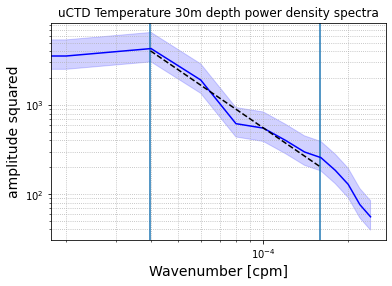

In [12]:
### Variables to adjust ###

pressure = 30
source = 'uctd'
interp_res = [0.5,1]
boxcar = 1
var='temp'
passes = [1,2,3,1,2,3,1,2,3]
min_seg = 50
transects=['T12','T12','T12','T34','T34','T34','T56','T56','T56','T78','T78','T78']
edges = [-4.4, -3.8]

###########################

fig, ax = plt.subplots(figsize=(6,4))

for edge in edges:
    ax.axvline(10**(edge))

freq, ps, psd, M, _, _, _, _ = get_spectra_upd(transects, pressure, source=source, interp_res=interp_res, boxcar=boxcar, passes=passes, var='temp_const', min_seg=min_seg)
idxs = freq < (1/4000)
freq = freq[idxs]
psd = psd.mean(axis=0)[idxs]
Eu, El = plot_spectra(fig, ax, freq, psd, M, 'temp', 'blue')

for i in range(len(edges)-1):
    m = spectral_slope_scipy(freq, psd, 10**(edges[i]), 10**(edges[i+1]), Eu, El, ax)[0]
    print(f"Temp Slope between {round(1/10**edges[0]/1000, 2)}km and {round(1/10**edges[1]/1000, 2)}km: {round(m, 2)}")

# ax.legend()
ax.set_title(f'uCTD Temperature {pressure}m depth power density spectra')
plt.savefig(f'../Figures/psd_{source}_{pressure}dbar_{var}_alldata.png')
plt.show()

27
Sal Slope between 25.12km and 6.31km: -2.5


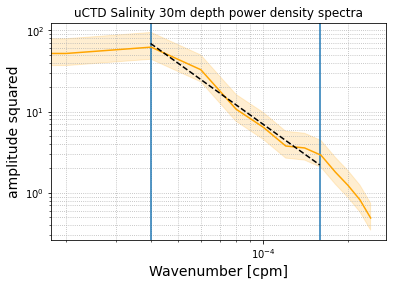

In [13]:
### Variables to adjust ###

pressure = 30
source = 'uctd'
interp_res = [0.5,1]
boxcar = 1
var='sal'
passes = [1,2,3,1,2,3,1,2,3]
min_seg = 50
transects=['T12','T12','T12','T34','T34','T34','T56','T56','T56','T78','T78','T78']
edges = [-4.4, -3.8]

###########################

fig, ax = plt.subplots(figsize=(6,4))

for edge in edges:
    ax.axvline(10**(edge))

freq, ps, psd, M, _, _, _, _ = get_spectra_upd(transects, pressure, source=source, interp_res=interp_res, boxcar=boxcar, passes=passes, var=var, min_seg=min_seg)
idxs = freq < (1/4000)
freq = freq[idxs]
psd = psd.mean(axis=0)[idxs]
Eu, El = plot_spectra(fig, ax, freq, psd, M, 'temp', 'orange')

for i in range(len(edges)-1):
    m = spectral_slope_scipy(freq, psd, 10**(edges[i]), 10**(edges[i+1]), Eu, El, ax)[0]
    print(f"Sal Slope between {round(1/10**edges[0]/1000, 2)}km and {round(1/10**edges[1]/1000, 2)}km: {round(m, 2)}")

# ax.legend()
ax.set_title(f'uCTD Salinity {pressure}m depth power density spectra')
plt.savefig(f'../Figures/psd_{source}_{pressure}dbar_{var}_alldata.png')
plt.show()

27
Density Slope between 25.12km and 6.31km: -1.83


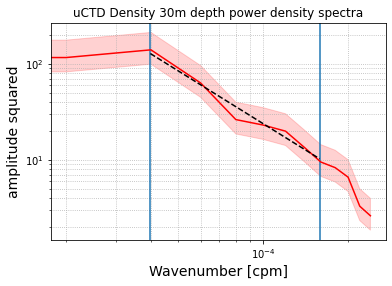

In [14]:
### Variables to adjust ###

pressure = 30
source = 'uctd'
interp_res = [0.5,1]
boxcar = 1
var='density'
passes = [1,2,3,1,2,3,1,2,3]
min_seg = 50
transects=['T12','T12','T12','T34','T34','T34','T56','T56','T56','T78','T78','T78']
edges = [-4.4, -3.8]

###########################

fig, ax = plt.subplots(figsize=(6,4))

for edge in edges:
    ax.axvline(10**(edge))

freq, ps, psd, M, _, _, _, _ = get_spectra_upd(transects, pressure, source=source, interp_res=interp_res, boxcar=boxcar, passes=passes, var=var, min_seg=min_seg)
idxs = freq < (1/4000)
freq = freq[idxs]
psd = psd.mean(axis=0)[idxs]
Eu, El = plot_spectra(fig, ax, freq, psd, M, 'temp', 'red')

for i in range(len(edges)-1):
    m = spectral_slope_scipy(freq, psd, 10**(edges[i]), 10**(edges[i+1]), Eu, El, ax)[0]
    print(f"Density Slope between {round(1/10**edges[0]/1000, 2)}km and {round(1/10**edges[1]/1000, 2)}km: {round(m, 2)}")

# ax.legend()
ax.set_title(f'uCTD Density {pressure}m depth power density spectra')
plt.savefig(f'../Figures/psd_{source}_{pressure}dbar_{var}_alldata.png')
plt.show()

10


C:\Users\Ryan Eusebi\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


Slope between 25.12km and 0.13km: -2.07


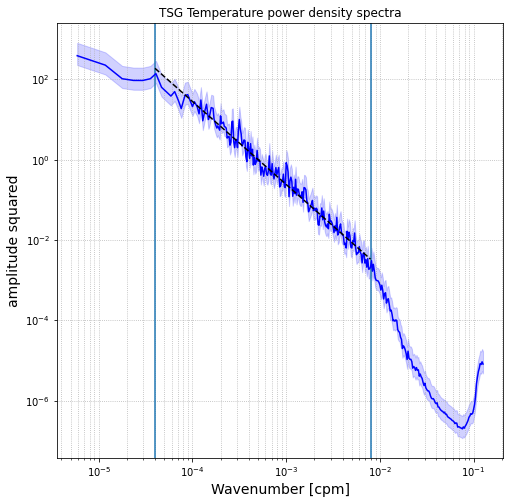

In [15]:
### Variables to adjust ###

pressure = 3.6
source = 'tsg'
interp_res = [4,4]
boxcar = 1
var='temp'
min_seg = 50
size=170

passes = [1,2,3,1,2,3,1,2,3,1,2,3]
min_seg = 50
transects=['T12','T12','T12','T34','T34','T34','T56','T56','T56','T78','T78','T78']
edges = [-4.4, -2.1]

###########################

fig, ax = plt.subplots(figsize=(8,8))

for edge in edges:
    ax.axvline(10**(edge))

freq, ps, psd, M, _, _, _, _ = get_spectra_fixed(transects, pressure, source=source, interp_res=interp_res, boxcar=boxcar, passes=passes, var=var, size=170)
psd = psd.mean(axis=0)
freq, psd = avg_per_decade(freq, psd, nbins=100)
Eu, El = plot_spectra(fig, ax, freq, psd, M, 'density', 'blue')

for i in range(len(edges)-1):
    m = spectral_slope_scipy(freq, psd, 10**(edges[i]), 10**(edges[i+1]), Eu, El, ax)[0]
    print(f"Slope between {round(1/10**edges[0]/1000, 2)}km and {round(1/10**edges[1]/1000, 2)}km: {round(m, 2)}")

# ax.legend()
ax.set_title(f'TSG Temperature power density spectra')
plt.savefig(f'../Figures/psd_{source}_{pressure}dbar_{var}_alldata.png')
plt.show()

10


C:\Users\Ryan Eusebi\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


Slope between 25.12km and 0.13km: -2.46


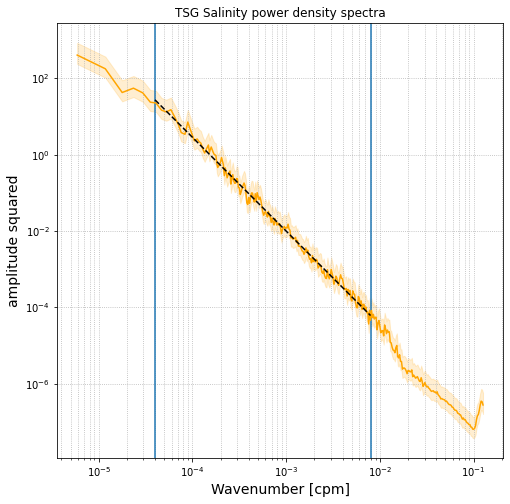

In [16]:
### Variables to adjust ###

pressure = 3.6
source = 'tsg'
interp_res = [4,4]
boxcar = 1
var='sal'
min_seg = 50
size=170

passes = [1,2,3,1,2,3,1,2,3,1,2,3]
min_seg = 50
transects=['T12','T12','T12','T34','T34','T34','T56','T56','T56','T78','T78','T78']
edges = [-4.4, -2.1]

###########################

fig, ax = plt.subplots(figsize=(8,8))

for edge in edges:
    ax.axvline(10**(edge))

freq, ps, psd, M, _, _, _, _ = get_spectra_fixed(transects, pressure, source=source, interp_res=interp_res, boxcar=boxcar, passes=passes, var=var, size=170)
psd = psd.mean(axis=0)
freq, psd = avg_per_decade(freq, psd, nbins=100)
Eu, El = plot_spectra(fig, ax, freq, psd, M, 'density', 'orange')

for i in range(len(edges)-1):
    m = spectral_slope_scipy(freq, psd, 10**(edges[i]), 10**(edges[i+1]), Eu, El, ax)[0]
    print(f"Slope between {round(1/10**edges[0]/1000, 2)}km and {round(1/10**edges[1]/1000, 2)}km: {round(m, 2)}")

# ax.legend()
ax.set_title(f'TSG Salinity power density spectra')
plt.savefig(f'../Figures/psd_{source}_{pressure}dbar_{var}_alldata.png')
plt.show()

10


C:\Users\Ryan Eusebi\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


Slope between 25.12km and 0.13km: -2.06


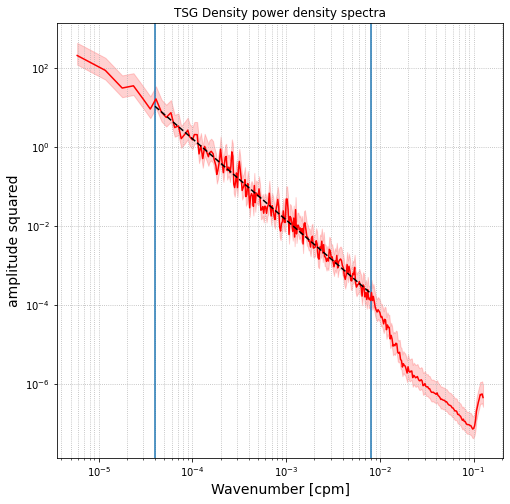

In [17]:
### Variables to adjust ###

pressure = 3.6
source = 'tsg'
interp_res = [4,4]
boxcar = 1
var='density'
min_seg = 50
size=170

passes = [1,2,3,1,2,3,1,2,3,1,2,3]
min_seg = 50
transects=['T12','T12','T12','T34','T34','T34','T56','T56','T56','T78','T78','T78']
edges = [-4.4, -2.1]

###########################

fig, ax = plt.subplots(figsize=(8,8))

for edge in edges:
    ax.axvline(10**(edge))

freq, ps, psd, M, _, _, _, _ = get_spectra_fixed(transects, pressure, source=source, interp_res=interp_res, boxcar=boxcar, passes=passes, var=var, size=170)
psd = psd.mean(axis=0)
freq, psd = avg_per_decade(freq, psd, nbins=100)
Eu, El = plot_spectra(fig, ax, freq, psd, M, 'density', 'red')

for i in range(len(edges)-1):
    m = spectral_slope_scipy(freq, psd, 10**(edges[i]), 10**(edges[i+1]), Eu, El, ax)[0]
    print(f"Slope between {round(1/10**edges[0]/1000, 2)}km and {round(1/10**edges[1]/1000, 2)}km: {round(m, 2)}")

# ax.legend()
ax.set_title(f'TSG Density power density spectra')
plt.savefig(f'../Figures/psd_{source}_{pressure}dbar_{var}_alldata.png')
plt.show()

# SSH Calculations
These are done at the actual cast locations, so no lateral interpolation

In [18]:
CT = gsw.CT_from_t(prof_uctd.sal_good, prof_uctd.temp_good, prof_uctd.pressure)
dyn_heights = gsw.geo_strf_dyn_height(prof_uctd.sal_good.values, CT.values, prof_uctd.pressure.values, axis=3, p_ref=200)
profs['dyn_height_anom'] = xr.DataArray(dyn_heights, coords=[prof_uctd.transect, prof_uctd.p, prof_uctd.cast, prof_uctd.pressure], dims=['transect', 'p','cast','pressure'])
heights = profs['dyn_height_anom'].sel(pressure=4) / 9.81

# Plot one cast on inputted transect and pass

Text(0.5, 1.0, 'SSH anomalies from upper 200dbar T56 pass 1')

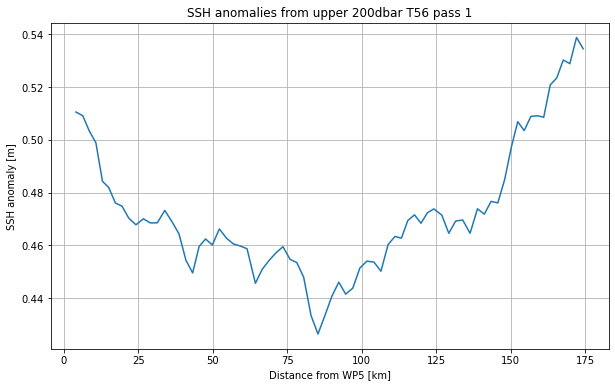

In [19]:
### Variables to adjust ###

transect = 'T56'
p=1

###########################

fig, ax = plt.subplots(figsize=(10,6))
h = heights.sel(transect=transect, p=p).sel(cast=slice(None, prof_uctd.sel(transect=transect, p=p).num_casts.item()-1))
ax.plot(prof_uctd.sel(transect=transect, p=p).sel(cast=slice(None, prof_uctd.sel(transect=transect, p=p).num_casts.item()-1)).dist_from_WP.values, h, label=f'pass {p}')
    
ax.grid()
ax.set_xlabel(f'Distance from WP{transect[1]} [km]')
ax.set_ylabel('SSH anomaly [m]')
ax.set_title(f'SSH anomalies from upper 200dbar {transect} pass {p}')

# Plotting all passes of one transect on same pass

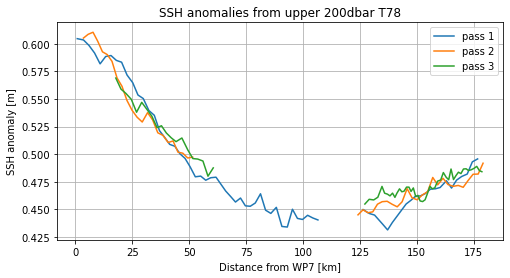

In [20]:
# Variables to adjust #

transect = 'T78'

#######################


fig, ax = plt.subplots(figsize=(8,4))

for p in range(1,4):
    h = heights.sel(transect=transect, p=p).sel(cast=slice(None, prof_uctd.sel(transect=transect, p=p).num_casts.item()-1))
    ax.plot(prof_uctd.sel(transect=transect, p=p).sel(cast=slice(None, prof_uctd.sel(transect=transect, p=p).num_casts.item()-1)).dist_from_WP.values, h, label=f'pass {p}')
    ax.grid()
    ax.set_xlabel(f'Distance from WP{transect[1]} [km]')
    ax.set_ylabel('SSH anomaly [m]')
    ax.set_title(f'SSH anomalies from upper 200dbar {transect}')
    ax.legend()
    
plt.savefig(f'../Figures/ssh_{transect}_allpasses.png')

# TSG Temp, salinity of all passes of one transect

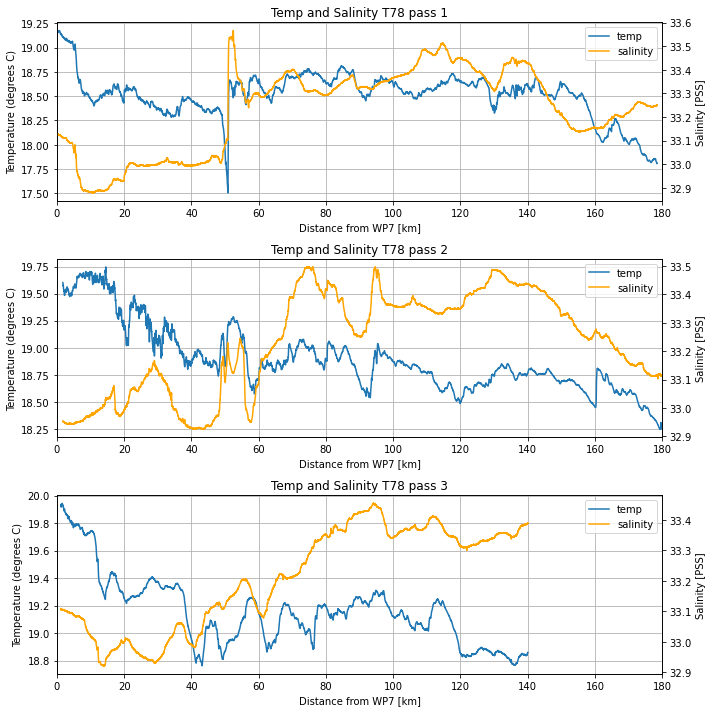

In [21]:
# Variables to adjust #

transect='T78'

#######################

fig, ax = plt.subplots(3,1, figsize=(10,10))

for p in range(1,4):
    temp = tsg_prof_for_fft(transect, p, interp_res = [4,4])
    lns1 = ax[p-1].plot(temp.dist, temp.temp_good, label=f'temp')
    ax[p-1].set_xlabel(f'Distance from WP{min(int(transect[1]), int(transect[2]))} [km]')
    ax[p-1].set_ylabel('Temperature (degrees C)')
    ax2 = ax[p-1].twinx()
    lns2 = ax2.plot(temp.dist, temp.sal_good, label='salinity', c='orange')
    ax2.set_ylabel('Salinity [PSS]')
    ax2.set_title(f'Temp and Salinity {transect} pass {p}')
    
    lns = lns1+lns2
    labs = [l.get_label() for l in lns]
    ax2.legend(lns, labs)
    
    ax[p-1].grid()
    ax[p-1].set_xlim([0,180])

plt.tight_layout()
plt.savefig(f'../Figures/tsg_temp_sal_{transect}_allpasses.png')
plt.show()

# TSG Density of all passes one transect

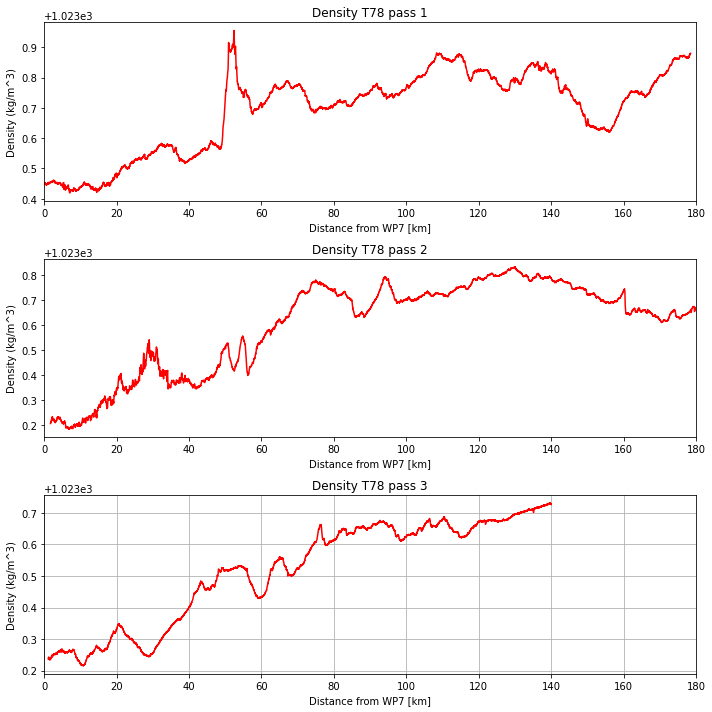

In [22]:
# Variables to adjust #

transect='T78'

#######################

fig, ax = plt.subplots(3,1, figsize=(10,10))

for p in range(1,4):
    temp = tsg_prof_for_fft(transect, p, interp_res = [4,4])
    lns1 = ax[p-1].plot(temp.dist, temp.density_good, label=f'density', c='red')
    ax[p-1].set_xlabel(f'Distance from WP{min(int(transect[1]), int(transect[2]))} [km]')
    ax[p-1].set_ylabel('Density (kg/m^3)')
    ax[p-1].set_title(f'Density {transect} pass {p}')
    
    lns = lns1+lns2
    labs = [l.get_label() for l in lns]
    ax2.legend(lns, labs)
    
    ax[p-1].grid
    ax[p-1].set_xlim([0,180])

plt.tight_layout()
plt.grid()
plt.savefig(f'../Figures/tsg_density_{transect}_allpasses.png')
plt.show()

# Plot temp, density, salinity of one transect one pass in one figure

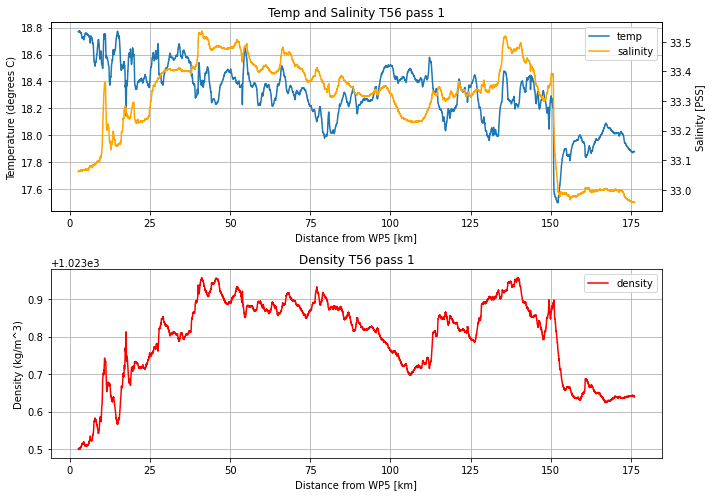

In [23]:
# Variables to adjust #

transect='T56'
p=1

#######################

fig, ax = plt.subplots(2,1, figsize=(10,7))

temp = tsg[(tsg.transect==transect)&(tsg.transect_pass==p)]
lns1 = ax[p-1].plot(temp.dist_from_WP, temp.temp, label=f'temp')
ax[0].set_xlabel(f'Distance from WP{min(int(transect[1]), int(transect[2]))} [km]')
ax[0].set_ylabel('Temperature (degrees C)')
ax2 = ax[0].twinx()
lns2 = ax2.plot(temp.dist_from_WP, temp.sal, label='salinity', c='orange')
ax2.set_ylabel('Salinity [PSS]')
ax2.set_title(f'Temp and Salinity {transect} pass {p}')

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs)

ax[0].grid()

temp = tsg_prof_for_fft(transect, p, interp_res = [4,4])
lns1 = ax[1].plot(temp.dist, temp.density_good, label=f'density', c='red')
ax[1].set_xlabel(f'Distance from WP{min(int(transect[1]), int(transect[2]))} [km]')
ax[1].set_ylabel('Density (kg/m^3)')
ax[1].set_title(f'Density {transect} pass {p}')

ax[1].legend()

ax[1].grid()

plt.tight_layout()
plt.show()

# uCTD density profiles all passes one transect

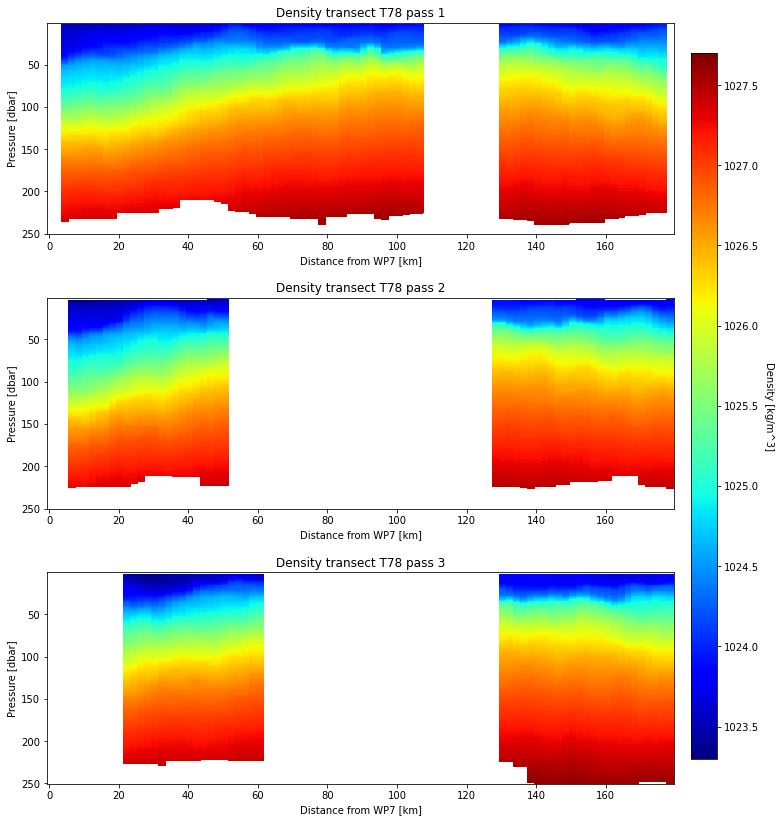

In [24]:
# Variables to adjust #

transect = 'T78'

#######################

fig, ax = plt.subplots(3, 1, figsize=(12,14))
for i in range(0,3):
    prof = prof_for_fft(transect, i+1)
    im = ax[i].pcolormesh(prof.dist, prof.pressure, prof.density_good.transpose(), shading='nearest', cmap='jet', vmin=1023.3, vmax=1027.7)
    ax[i].invert_yaxis()
    ax[i].set_xlabel(f'Distance from WP{transect[1]} [km]')
    ax[i].set_ylabel('Pressure [dbar]')
    ax[i].set_title(f'Density transect {transect} pass {i+1}')
    
fig.subplots_adjust(right=0.85, hspace=0.3)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel('Density [kg/m^3]', rotation=270, labelpad=15)
plt.savefig(f'../Figures/uctd_profiles_density_{transect}_allpasses.png')
plt.show()

# uCTD salinity profiles all passes one transect

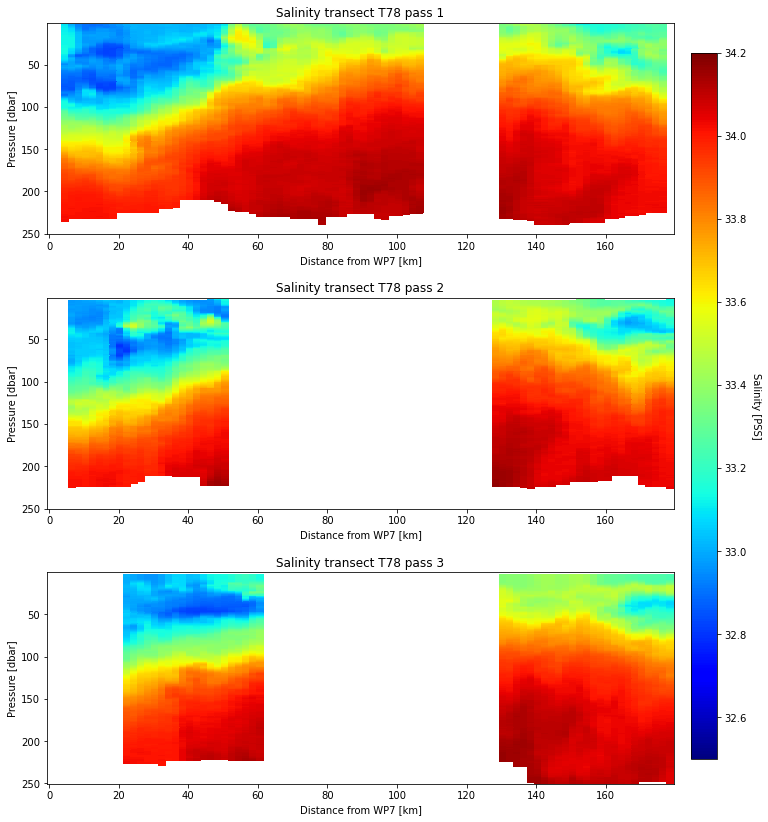

In [25]:
# Variables to adjust #

transect = 'T78'

#######################

fig, ax = plt.subplots(3, 1, figsize=(12,14))
for i in range(0,3):
    
    prof = prof_for_fft(transect, i+1)
    im = ax[i].pcolormesh(prof.dist, prof.pressure, prof.sal_good.transpose(), shading='nearest', cmap='jet', vmax=34.2, vmin=32.5)
    ax[i].invert_yaxis()
    ax[i].set_xlabel(f'Distance from WP{transect[1]} [km]')
    ax[i].set_ylabel('Pressure [dbar]')
    ax[i].set_title(f'Salinity transect {transect} pass {i+1}')   
fig.subplots_adjust(right=0.85, hspace=0.3)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel('Salinity [PSS]', rotation=270, labelpad=15)
plt.savefig(f'../Figures/uctd_profiles_sal_{transect}_allpasses.png')
plt.show()

# uCTD temperature profiles all passes one transect

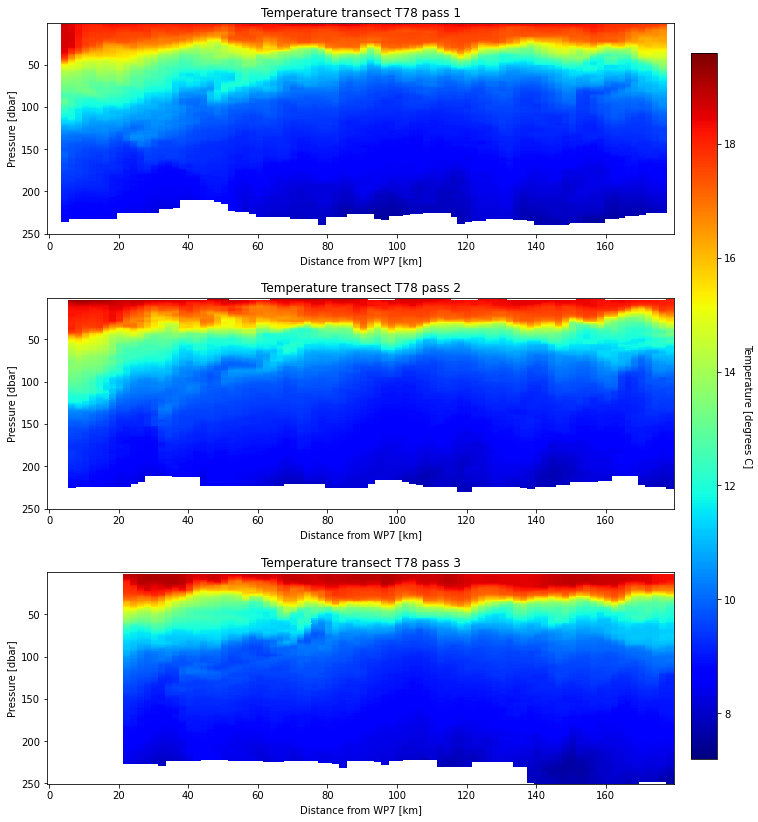

In [26]:
# Variables to adjust #

transect = 'T78'

#######################

fig, ax = plt.subplots(3, 1, figsize=(12,14))
for i in range(0,3):
    
    prof = prof_for_fft(transect, i+1)
    im = ax[i].pcolormesh(prof.dist, prof.pressure, prof.temp_good.transpose(), shading='nearest', cmap='jet', vmax=19.6, vmin=7.2)
    ax[i].invert_yaxis()
    ax[i].set_xlabel(f'Distance from WP{transect[1]} [km]')
    ax[i].set_ylabel('Pressure [dbar]')
    ax[i].set_title(f'Temperature transect {transect} pass {i+1}')
    
fig.subplots_adjust(right=0.85, hspace=0.3)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel('Temperature [degrees C]', rotation=270, labelpad=15)
plt.savefig(f'../Figures/uctd_profiles_temp_{transect}_allpasses.png')
plt.show()